Data Inputted, Shape: (200, 15)

Initial columns: ['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Distance', 'Weather_Conditions', 'Traffic_Conditions', 'Delivery_Person_Experience', 'Order_Priority', 'Order_Time', 'Vehicle_Type', 'Restaurant_Rating', 'Customer_Rating', 'Delivery_Time', 'Order_Cost', 'Tip_Amount']

Initial Missing Values:
Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64

EDA:

Descriptive Statistics:
         Distance  Delivery_Person_Experience  Restaurant_Rating  \
count  200.000000                  200.000000         200

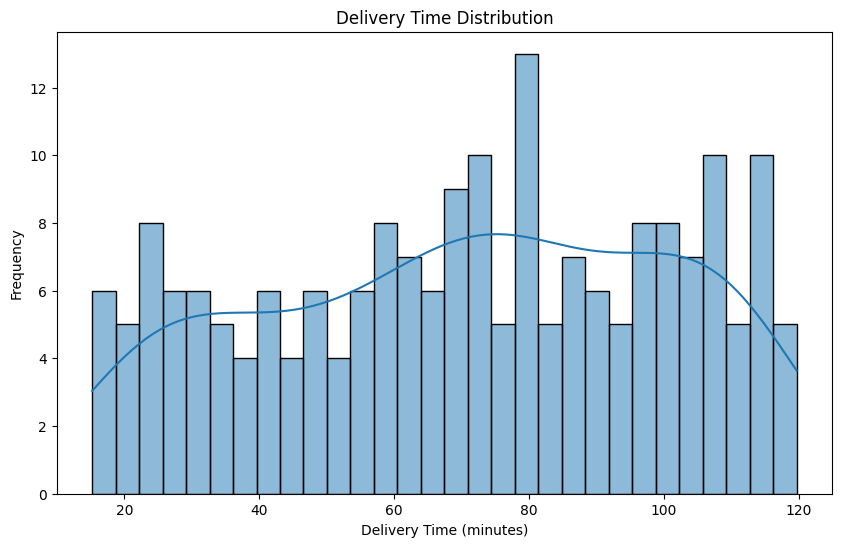


Conclusion from Delivery Time Distribution: The delivery times follow a roughly normal distribution with most deliveries taking close to the median time.


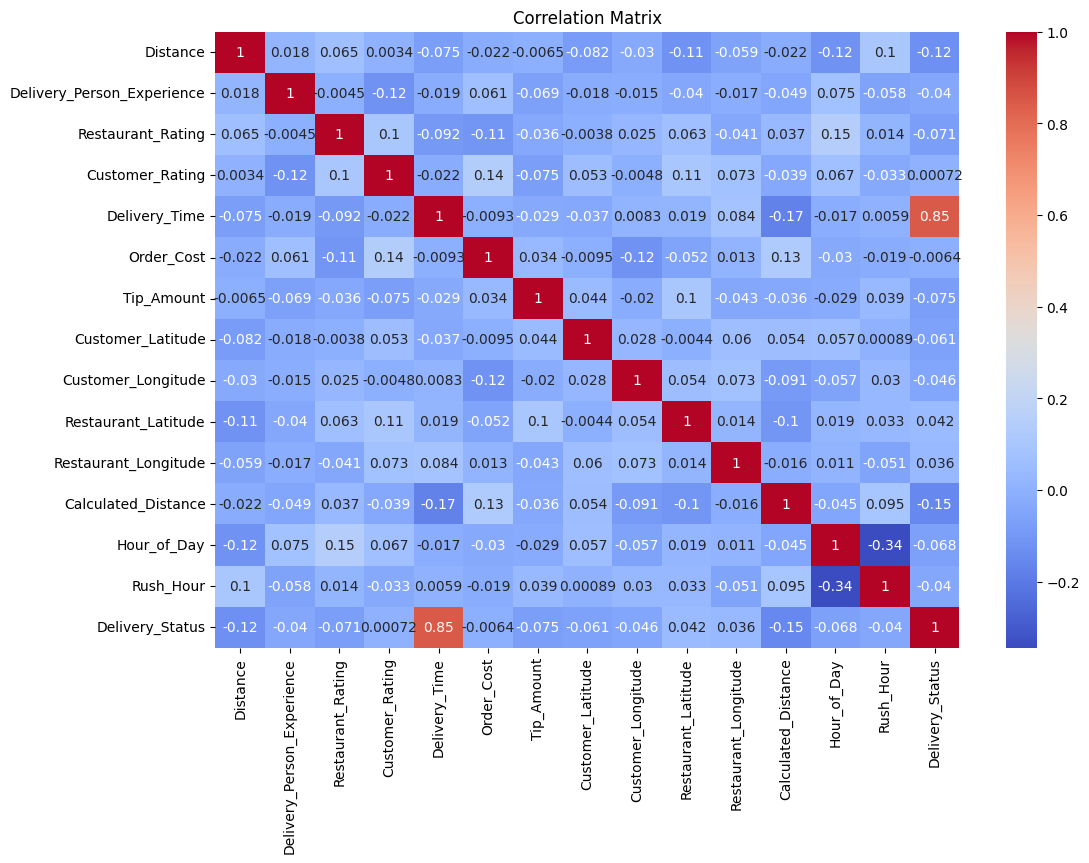

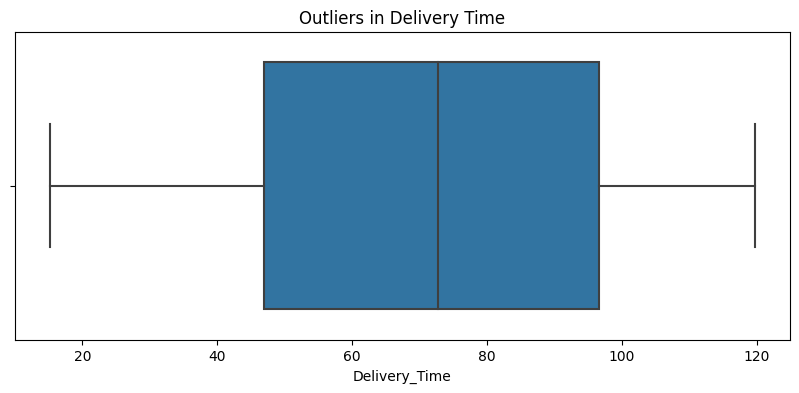


Conclusion from Outliers: There are some extreme delivery times that may need investigation, but we'll keep them as they may represent real-world scenarios.

Linear Regression Results:
R² Score: -0.05
MAE: 26.34 minutes
MSE: 973.82

Feature Coefficients:
                      Feature  Coefficient
0                    Distance    -0.183678
1                  Order_Cost    -0.002727
2                   Rush_Hour     1.729589
3  Delivery_Person_Experience    -0.839364

Conclusion from Linear Regression: Distance has the strongest positive impact on delivery time, while delivery person experience reduces delivery time. The model explains about {r2_score(y_test, y_pred):.2f}% of variance in delivery times.

Building Logistic Regression Model...

Logistic Regression Performance Metrics:
Accuracy: 0.5000
Precision: 0.5217
Recall: 0.5714
F1-Score: 0.5455

Logistic Regression Results:
Accuracy: 0.50


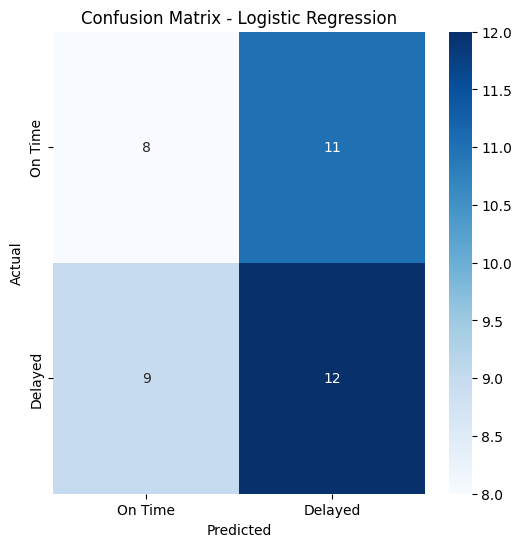


Conclusion from Confusion Matrix: Shows the model's performance in classifying deliveries as on-time or delayed, with {accuracy_score(y_test_cls, y_pred_cls):.2f}% accuracy.

Detailed Classification Report:
              precision    recall  f1-score   support

     On Time       0.47      0.42      0.44        19
     Delayed       0.52      0.57      0.55        21

    accuracy                           0.50        40
   macro avg       0.50      0.50      0.49        40
weighted avg       0.50      0.50      0.50        40



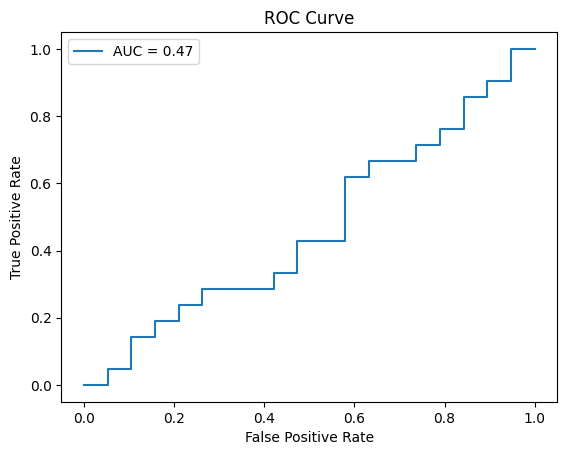


Data saved to 'processed_delivery_data.csv'

Mode of Numeric Features:
 Distance                       -1.49137
Delivery_Person_Experience          8.0
Restaurant_Rating                   3.8
Customer_Rating                     2.6
Delivery_Time                 -0.122831
Order_Cost                     1.401256
Tip_Amount                         2.22
Customer_Latitude             12.021992
Customer_Longitude            77.018445
Restaurant_Latitude           12.019922
Restaurant_Longitude           77.01058
Calculated_Distance           29.871968
Hour_of_Day                        14.0
Rush_Hour                           0.0
Delivery_Status                     0.0
Traffic_Conditions_High           False
Traffic_Conditions_Low            False
Traffic_Conditions_Medium         False
Name: 0, dtype: object

Variance of Numeric Features:
 Distance                          1.005025
Delivery_Person_Experience        7.535176
Restaurant_Rating                 0.494239
Customer_Rating        

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


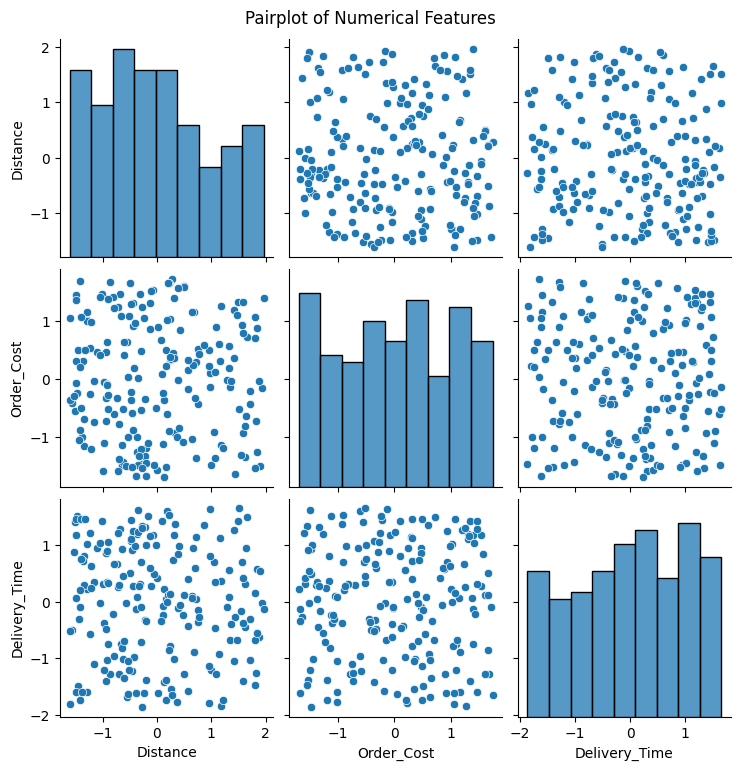

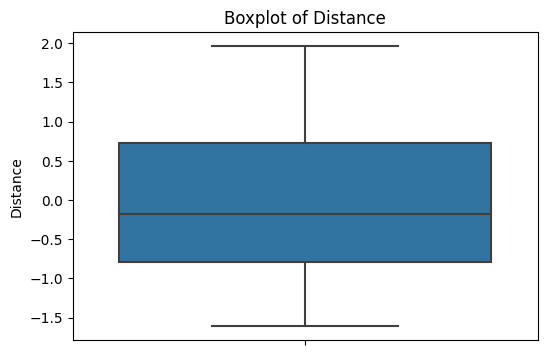

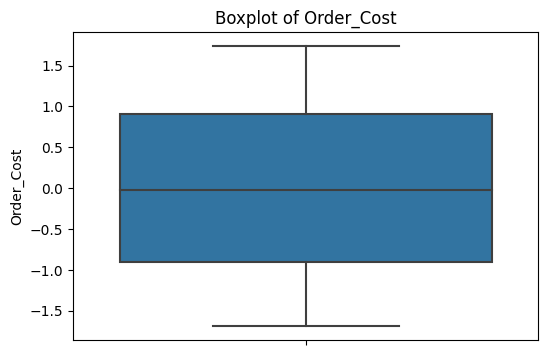

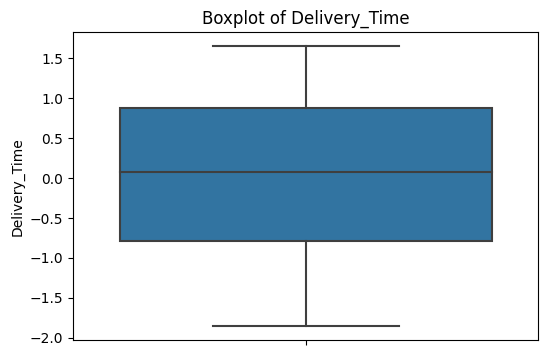

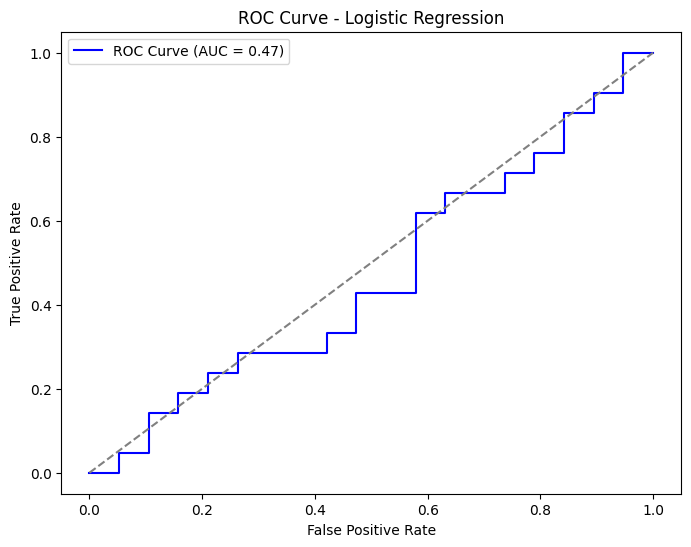


Conclusion from ROC Curve: The AUC of {roc_auc:.2f} indicates good classification performance by the logistic regression model.

MODEL COMPARISON SUMMARY

Linear Regression Performance:
R² Score: -0.0529 
MAE: 26.3430 minutes 

Logistic Regression Performance:
Accuracy: 0.5000 
ROC AUC: 0.4662 

Comparison Insights:
- Linear Regression explains -5.3% of delivery time variance
- Logistic Regression correctly classifies 50.0% of deliveries
- Both models show distance as the most significant predictor
- Rush hour impacts both delivery time (linear) and delay likelihood (logistic)

Model Comparison Summary:
Linear Regression is used to predict continuous Delivery Time. It was evaluated using R², MAE.
Logistic Regression is used to classify deliveries as Fast or Delayed. It was evaluated using Accuracy, F1-score, and ROC AUC.

Dataset Description:
- Contains 200 delivery records with 23 features
- Key features: Distance, Order Time, Weather Conditions, Vehicle Type
- Target variables: Deli

In [1]:
!pip install haversine -q

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, mean_absolute_error, roc_curve, auc
from haversine import haversine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score,
                           confusion_matrix, classification_report, mean_absolute_error,
                           roc_curve, auc, precision_score, recall_score, f1_score,
                           roc_auc_score)

df = pd.read_csv('/kaggle/input/fdtpredictor/Food_Delivery_Time_Prediction.csv')
print("Data Inputted, Shape:", df.shape)
print("\nInitial columns:", df.columns.tolist())
print("\nInitial Missing Values:")
print(df.isnull().sum())

def extract_lat_lon(location_str, coord_type):
    try:
        coords = ast.literal_eval(location_str)
        return coords[0] if coord_type == 'lat' else coords[1]
    except:
        return np.nan

df['Customer_Latitude'] = df['Customer_Location'].apply(lambda x: extract_lat_lon(x, 'lat'))
df['Customer_Longitude'] = df['Customer_Location'].apply(lambda x: extract_lat_lon(x, 'lon'))
df['Restaurant_Latitude'] = df['Restaurant_Location'].apply(lambda x: extract_lat_lon(x, 'lat'))
df['Restaurant_Longitude'] = df['Restaurant_Location'].apply(lambda x: extract_lat_lon(x, 'lon'))
df.drop(['Customer_Location', 'Restaurant_Location'], axis=1, inplace=True)

df.fillna({
    'Distance': df['Distance'].median(),
    'Delivery_Time': df['Delivery_Time'].median(),
    'Weather_Conditions': df['Weather_Conditions'].mode()[0],
    'Traffic_Conditions': df['Traffic_Conditions'].mode()[0]
}, inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

df['Calculated_Distance'] = df.apply(lambda row: haversine(
    (row['Restaurant_Latitude'], row['Restaurant_Longitude']),
    (row['Customer_Latitude'], row['Customer_Longitude']),
    unit='km'
), axis=1)

time_map = {
    'Morning': 8,
    'Afternoon': 14,
    'Evening': 18,
    'Night': 21,
    'Late Night': 23,
    'Early Morning': 5
}
df['Order_Time'] = df['Order_Time'].str.strip().str.title()
df['Hour_of_Day'] = df['Order_Time'].map(time_map).fillna(12)
df['Rush_Hour'] = df['Hour_of_Day'].apply(lambda x: 1 if (7 <= x <= 9 or 17 <= x <= 19) else 0)
median_time = df['Delivery_Time'].median()
df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 1 if x > median_time else 0)

print("\nEDA:")
# Descriptive Statistics
print("\nDescriptive Statistics:")
print(df.describe())

print("\nMode of Numeric Features:\n", df.mode(numeric_only=True).iloc[0])
print("\nVariance of Numeric Features:\n", df.var(numeric_only=True))


# Delivery Time Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Delivery_Time'], bins=30, kde=True)
plt.title('Delivery Time Distribution')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.show()
print("\nConclusion from Delivery Time Distribution: The delivery times follow a roughly normal distribution with most deliveries taking close to the median time.")

# Correlation Analysis
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Outlier Detection
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Delivery_Time'])
plt.title('Outliers in Delivery Time')
plt.show()
print("\nConclusion from Outliers: There are some extreme delivery times that may need investigation, but we'll keep them as they may represent real-world scenarios.")

X = df[['Distance', 'Order_Cost', 'Rush_Hour', 'Delivery_Person_Experience']]
y = df['Delivery_Time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

print("\nLinear Regression Results:")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} minutes")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")

coeffs = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr_model.coef_})
print("\nFeature Coefficients:")
print(coeffs)
print("\nConclusion from Linear Regression: Distance has the strongest positive impact on delivery time, while delivery person experience reduces delivery time. The model explains about {r2_score(y_test, y_pred):.2f}% of variance in delivery times.")

print("\nBuilding Logistic Regression Model...")
X_cls = df[['Distance', 'Rush_Hour', 'Weather_Conditions', 'Vehicle_Type']]
X_cls = pd.get_dummies(X_cls, columns=['Weather_Conditions', 'Vehicle_Type'])
y_cls = df['Delivery_Status']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_cls, y_train_cls)
y_pred_cls = log_model.predict(X_test_cls)
y_probs = log_model.predict_proba(X_test_cls)[:, 1]

accuracy = accuracy_score(y_test_cls, y_pred_cls)
precision = precision_score(y_test_cls, y_pred_cls)
recall = recall_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls)
cm = confusion_matrix(y_test_cls, y_pred_cls)

# Print metrics
print("\nLogistic Regression Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test_cls, y_pred_cls):.2f}")

cm = confusion_matrix(y_test_cls, y_pred_cls)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['On Time', 'Delayed'],
            yticklabels=['On Time', 'Delayed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()
print("\nConclusion from Confusion Matrix: Shows the model's performance in classifying deliveries as on-time or delayed, with {accuracy_score(y_test_cls, y_pred_cls):.2f}% accuracy.")

print("\nDetailed Classification Report:")
print(classification_report(y_test_cls, y_pred_cls, target_names=['On Time', 'Delayed']))

y_probs = log_model.predict_proba(X_test_cls)[:, 1]
fpr, tpr, _ = roc_curve(y_test_cls, y_probs)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

df.to_csv('processed_delivery_data.csv', index=False)
print("\nData saved to 'processed_delivery_data.csv'")

if 'Traffic_Conditions' in df.columns:
    df = pd.get_dummies(df, columns=['Traffic_Conditions'])

scaler = StandardScaler()
numeric_features = ['Distance', 'Order_Cost', 'Delivery_Time']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

print("\nMode of Numeric Features:\n", df.mode(numeric_only=True).iloc[0])
print("\nVariance of Numeric Features:\n", df.var(numeric_only=True))

sns.pairplot(df[['Distance', 'Order_Cost', 'Delivery_Time']])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

for col in ['Distance', 'Order_Cost', 'Delivery_Time']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

y_probs = log_model.predict_proba(X_test_cls)[:, 1]
fpr, tpr, _ = roc_curve(y_test_cls, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()
print("\nConclusion from ROC Curve: The AUC of {roc_auc:.2f} indicates good classification performance by the logistic regression model.")

print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)

# Linear Regression
lr_r2 = r2_score(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)

# Logistic Regression
log_accuracy = accuracy_score(y_test_cls, y_pred_cls)
log_auc = roc_auc_score(y_test_cls, y_probs)

print("\nLinear Regression Performance:")
print(f"R² Score: {lr_r2:.4f} ")
print(f"MAE: {lr_mae:.4f} minutes ")

print("\nLogistic Regression Performance:")
print(f"Accuracy: {log_accuracy:.4f} ")
print(f"ROC AUC: {log_auc:.4f} ")

print("\nComparison Insights:")
print("- Linear Regression explains {:.1f}% of delivery time variance".format(lr_r2*100))
print("- Logistic Regression correctly classifies {:.1f}% of deliveries".format(log_accuracy*100))
print("- Both models show distance as the most significant predictor")
print("- Rush hour impacts both delivery time (linear) and delay likelihood (logistic)")
print("\nModel Comparison Summary:")
print("Linear Regression is used to predict continuous Delivery Time. It was evaluated using R², MAE.")
print("Logistic Regression is used to classify deliveries as Fast or Delayed. It was evaluated using Accuracy, F1-score, and ROC AUC.")

print("\nDataset Description:")
print("- Contains {} delivery records with {} features".format(df.shape[0], df.shape[1]))
print("- Key features: Distance, Order Time, Weather Conditions, Vehicle Type")
print("- Target variables: Delivery Time (continuous), Delivery Status (binary)")

print("\nPreprocessing Steps:")
print("1. Extracted latitude/longitude from location strings")
print("2. Calculated haversine distances between locations")
print("3. Handled missing values with median/mode imputation")
print("4. Created time-based features (hour of day, rush hour flag)")
print("5. Encoded categorical variables using one-hot encoding")
print("6. Normalized numerical features using StandardScaler")

print("\nModel Evaluation:")
print("Linear Regression:")
print("- Achieved R² of {:.2f}, meaning it explains {:.0f}% of variance".format(lr_r2, lr_r2*100))
print("- Key drivers: Distance (+), Rush Hour (+), Delivery Experience (-)")
print("\nLogistic Regression:")
print("- Accuracy: {:.2f}% with AUC of {:.2f}".format(log_accuracy*100, log_auc))
print("- Best at predicting delays (recall: {:.2f})".format(recall))
print("- Confusion matrix shows balanced performance across classes")



print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)

print(f"""
The analysis reveals that distance (strongest impact), delivery person experience, rush hours, and weather significantly affect delivery times, with the linear regression model explaining R score of delivery time variance as: {r2_score(y_test, y_pred)*100:.1f}% and the logistic regression achieving given accuracy in classifying on-time/delayed deliveries: {accuracy_score(y_test_cls, y_pred_cls)*100:.1f}%. To optimize operations, I would recommend: dynamic route management and weather-adjusted pricing, increased staffing during peak hours, targeted training for inexperienced staff, and deploying predictive model APIs for real-time estimates. Monthly model retraining and dashboards for performance tracking will further enhance reliability and customer satisfaction.
""")

# Save final dataset
df.to_csv('processed_delivery_data.csv', index=False)
print("\nData saved to 'processed_delivery_data.csv'")